<a href="https://colab.research.google.com/github/himanshu230998/CS504-project/blob/main/Chaotic_system_double_pendulum_return_seq_true_sequence_length(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pickle
from itertools import *

import csv

import matplotlib.animation as animation
import random
import matplotlib.patches as mpatches
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf


from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 2.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 2.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

# derivs(state,t) returns array of 4 number [Z1, Z1_dot, Z2, Z2_dot]
def derivs(state, t):
    
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_) #del1=L1*(M1+M2*sin(del)*sin(del))
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

 
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([75, 0, 50, 0])
y = integrate.odeint(derivs, state, t)   #len(y)=9999
x1 = 1 * sin(y[:, 0])
y1 = 1 * cos(y[:, 0])
x2 = 1 * sin(y[:, 2]) + x1
y2 = 1 * cos(y[:, 2]) + y1
for i in range(len(x1)):
    # all=[x1[i],y1[i],x2[i],y2[i]]
    arr.append(np.array([x1[i],y1[i],x2[i],y2[i]]))

In [ ]:
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([170, 0.1, 150, 0.1])
y = integrate.odeint(derivs, state, t)  
z1 = y[:,0]
z1_dot = y[:,1]
z2 = y[:,2]
z2_dot = y[:,3]

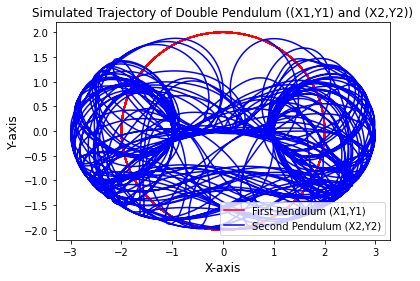

In [ ]:
plt.figure()
plt.title('Simulated Trajectory of Double Pendulum ((X1,Y1) and (X2,Y2))')
plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)
plt.plot(L1*sin(z1), -L1*cos(z1),label='First Pendulum (X1,Y1)' ,color="RED")
plt.plot(L2*sin(z2)+L1*sin(z1), -L2*cos(z2)-L2*cos(z1),label='Second Pendulum (X2,Y2)' ,color="BLUE")
plt.legend()
# plt.plot(z2_dot+sin(data[:,3][8100:10000]),-cos(data[:,1][8100:10000])-cos(data[:,3][8100:10000]),color="blue")

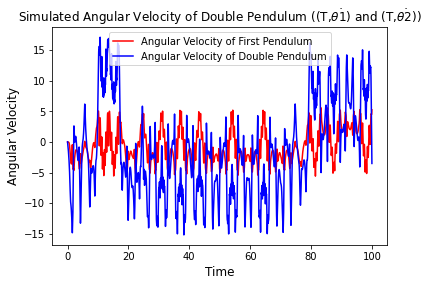

In [ ]:
plt.figure()
plt.title('Simulated Angular Velocity of Double Pendulum ((T,$\\dot{\\theta1}$) and (T,$\\dot{\\theta2}$))')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity', fontsize=12)
plt.plot(t,z1_dot,label='Angular Velocity of First Pendulum' ,color="RED")
plt.plot(t,z2_dot+z1_dot,label='Angular Velocity of Double Pendulum' ,color="blue")
plt.legend()

In [ ]:
import csv
with open('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv', 'w', newline='') as file:
    fieldnames = ['Time', 'Z1','Z1_dot','Z2','Z2_dot']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow({'Time': "Time", 'Z1':"Z1",'Z1_dot': "Z1_dot",'Z2':"Z2",'Z2_dot':"Z2_dot"})
    for i in range(0,len(t)):
        writer.writerow({'Time': t[i], 'Z1':z1[i],'Z1_dot': z1_dot[i],'Z2':z2[i],'Z2_dot':z2_dot[i]})

##Data process

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv')

In [ ]:
df

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,2.967060,0.001745,2.617994,0.001745
1,0.01,2.967071,0.000564,2.617777,-0.045040
2,0.02,2.967071,-0.000614,2.617093,-0.091870
3,0.03,2.967059,-0.001786,2.615940,-0.138792
4,0.04,2.967035,-0.002948,2.614317,-0.185850
...,...,...,...,...,...
9995,99.95,-75.037511,4.791539,-74.064910,-6.420650
9996,99.96,-74.989103,4.892429,-74.132048,-7.009447
9997,99.97,-74.939623,5.005246,-74.205137,-7.609281
9998,99.98,-74.888975,5.124689,-74.284219,-8.204247


In [ ]:
df_input=df[['Time', 'Z1','Z1_dot','Z2','Z2_dot']]
df_input

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,2.967060,0.001745,2.617994,0.001745
1,0.01,2.967071,0.000564,2.617777,-0.045040
2,0.02,2.967071,-0.000614,2.617093,-0.091870
3,0.03,2.967059,-0.001786,2.615940,-0.138792
4,0.04,2.967035,-0.002948,2.614317,-0.185850
...,...,...,...,...,...
9995,99.95,-75.037511,4.791539,-74.064910,-6.420650
9996,99.96,-74.989103,4.892429,-74.132048,-7.009447
9997,99.97,-74.939623,5.005246,-74.205137,-7.609281
9998,99.98,-74.888975,5.124689,-74.284219,-8.204247


In [ ]:
with open('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader)).astype(float)
print(headers)
print(data.shape)
print(data)

['Time', 'Z1', 'Z1_dot', 'Z2', 'Z2_dot']
(10000, 5)
[[ 0.00000000e+00  2.96705973e+00  1.74532925e-03  2.61799388e+00
   1.74532925e-03]
 [ 1.00000000e-02  2.96707127e+00  5.63564525e-04  2.61777743e+00
  -4.50396197e-02]
 [ 2.00000000e-02  2.96707101e+00 -6.14391016e-04  2.61709293e+00
  -9.18703132e-02]
 ...
 [ 9.99700000e+01 -7.49396228e+01  5.00524553e+00 -7.42051368e+01
  -7.60928095e+00]
 [ 9.99800000e+01 -7.48889754e+01  5.12468907e+00 -7.42842185e+01
  -8.20424677e+00]
 [ 9.99900000e+01 -7.48371386e+01  5.24108075e+00 -7.43691080e+01
  -8.76449866e+00]]


In [ ]:
data[:,0][8001:10001]

array([80.01, 80.02, 80.03, ..., 99.97, 99.98, 99.99])

In [ ]:
data[:,1][8001:10001]

array([-98.81955865, -98.78353303, -98.74879521, ..., -74.93962277,
       -74.88897536, -74.83713856])

In [ ]:
df_input.describe()

,Time,Z1,Z1_dot,Z2,Z2_dot
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.995000,-51.685145,-0.777779,-70.853455,-0.770313
std,28.868957,33.078620,2.660614,75.269919,7.150109
min,0.000000,-103.235297,-5.591118,-185.513441,-14.345969
25%,24.997500,-82.370348,-2.785079,-132.964763,-6.585843
50%,49.995000,-50.423740,-1.426719,-82.584954,-1.046103
75%,74.992500,-19.573909,1.324080,-5.351512,3.894342
max,99.990000,2.967071,5.558517,65.997184,17.534125


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.00000000e+00, 9.99999891e-01, 5.01618538e-01, 7.48005915e-01,
        4.50052441e-01],
       [1.00010001e-04, 1.00000000e+00, 5.01512546e-01, 7.48005055e-01,
        4.48584913e-01],
       [2.00020002e-04, 9.99999998e-01, 5.01406897e-01, 7.48002333e-01,
        4.47115949e-01],
       ...,
       [9.99799980e-01, 2.66431668e-01, 9.50377638e-01, 4.42559055e-01,
        2.11313304e-01],
       [9.99899990e-01, 2.66908563e-01, 9.61090413e-01, 4.42244628e-01,
        1.92650692e-01],
       [1.00000000e+00, 2.67396658e-01, 9.71529470e-01, 4.41907110e-01,
        1.75076971e-01]])

In [ ]:
features=data_scaled
target=data_scaled

In [ ]:
x_train=features[0:8000]
y_train=target[0:8000]
x_test=features[8000:10000]
y_test=target[8000:10000]

In [ ]:
win_length=10
batch_size=1
num_features=5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
X=np.array(([train_generator[0][0][0,:]]))
Y1=np.array(np.vstack((train_generator[0][1][:,0])))
Y2=np.array(np.vstack((train_generator[0][1][:,1])))
Y3=np.array(np.vstack((train_generator[0][1][:,2])))
Y4=np.array(np.vstack((train_generator[0][1][:,3])))
Y5=np.array(np.vstack((train_generator[0][1][:,4])))

for i in range(1,7990):
    X=np.vstack((X,[train_generator[i][0][0,:]]))
    Y1=np.vstack((Y1,train_generator[i][1][:,0]))
    Y2=np.vstack((Y2,train_generator[i][1][:,1]))
    Y3=np.vstack((Y3,train_generator[i][1][:,2]))
    Y4=np.vstack((Y4,train_generator[i][1][:,3]))
    Y5=np.vstack((Y5,train_generator[i][1][:,4]))

In [ ]:
title_input = keras.Input(shape= (win_length, num_features), name="title_input") 
title_features = layers.Dense(5)(title_input)

LSTM1 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM2 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM3 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM4 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM5 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)

LSTM6 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM1)
LSTM7 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM2)
LSTM8 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM3)
LSTM9 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM4)
LSTM10 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM5)

out1=layers.Dense(1,name="out1")(LSTM6)
out2=layers.Dense(1,name="out2")(LSTM7)
out3=layers.Dense(1,name="out3")(LSTM8)
out4=layers.Dense(1,name="out4")(LSTM9)
out5=layers.Dense(1,name="out5")(LSTM10)

model = keras.Model(
    inputs=[title_input],
    outputs=[out1, out2,out3,out4,out5],
)

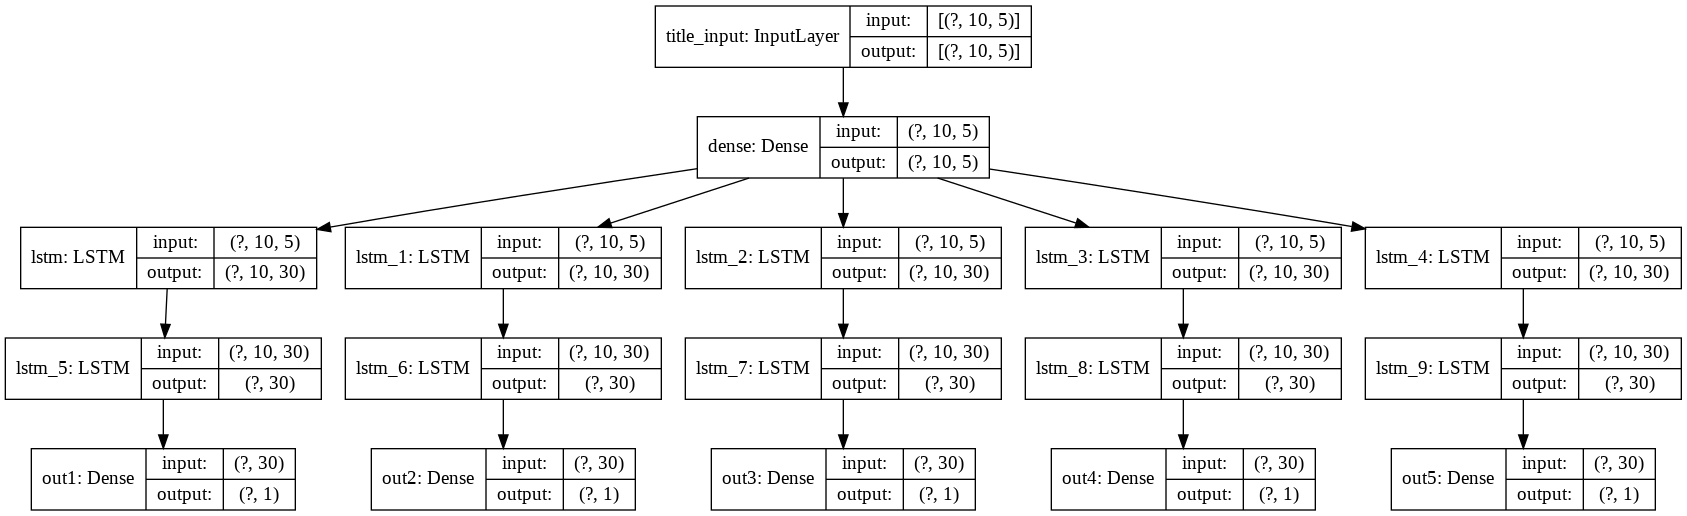

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(    {"title_input": X},
    {"out1": Y1, "out2": Y2, "out3": Y3, "out4": Y4, "out5": Y5,}, 
    epochs=30, validation_batch_size=0.1,
    shuffle=False)

Epoch 1/30
250/250 [==============================] - 6s 26ms/step - loss: 0.1000 - out1_loss: 5.4705e-04 - out2_loss: 0.0450 - out3_loss: 0.0129 - out4_loss: 0.0254 - out5_loss: 0.0162 - out1_mean_absolute_error: 0.0180 - out2_mean_absolute_error: 0.0926 - out3_mean_absolute_error: 0.0752 - out4_mean_absolute_error: 0.0804 - out5_mean_absolute_error: 0.0869
Epoch 2/30
250/250 [==============================] - 6s 25ms/step - loss: 0.0313 - out1_loss: 0.0081 - out2_loss: 0.0061 - out3_loss: 0.0042 - out4_loss: 0.0093 - out5_loss: 0.0036 - out1_mean_absolute_error: 0.0427 - out2_mean_absolute_error: 0.0365 - out3_mean_absolute_error: 0.0472 - out4_mean_absolute_error: 0.0524 - out5_mean_absolute_error: 0.0459
Epoch 3/30
250/250 [==============================] - 6s 24ms/step - loss: 0.0218 - out1_loss: 0.0086 - out2_loss: 0.0013 - out3_loss: 0.0037 - out4_loss: 0.0048 - out5_loss: 0.0034 - out1_mean_absolute_error: 0.0412 - out2_mean_absolute_error: 0.0219 - out3_mean_absolute_error: 0.

In [ ]:
model.evaluate_generator(test_generator, verbose=2)  
o1,o2,o3,o4,o5=model.predict_generator(test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1990/1990 - 19s - loss: 1.0776 - out1_loss: 0.1804 - out2_loss: 0.3161 - out3_loss: 0.1437 - out4_loss: 0.2984 - out5_loss: 0.1389 - out1_mean_absolute_error: 0.3427 - out2_mean_absolute_error: 0.4683 - out3_mean_absolute_error: 0.3065 - out4_mean_absolute_error: 0.4500 - out5_mean_absolute_error: 0.2992
Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
testX=np.array(([test_generator[0][0][0,:]]))
testY1=np.array(np.vstack((test_generator[0][1][:,0])))
testY2=np.array(np.vstack((test_generator[0][1][:,1])))
testY3=np.array(np.vstack((test_generator[0][1][:,2])))
testY4=np.array(np.vstack((test_generator[0][1][:,3])))
testY5=np.array(np.vstack((test_generator[0][1][:,4])))

for i in range(1,1990):
    testX=np.vstack((X,[test_generator[i][0][0,:]]))
    testY1=np.vstack((Y1,test_generator[i][1][:,0]))
    testY2=np.vstack((Y2,test_generator[i][1][:,1]))
    testY3=np.vstack((Y3,test_generator[i][1][:,2]))
    testY4=np.vstack((Y4,test_generator[i][1][:,3]))
    testY5=np.vstack((Y5,test_generator[i][1][:,4]))

In [ ]:
df_pred=pd.concat([pd.DataFrame(o1), pd.DataFrame(o2),pd.DataFrame(o3),pd.DataFrame(o4),pd.DataFrame(o5)],axis=1)

In [ ]:
df_pred

,0,0,0,0,0
0,0.785714,0.059076,0.704203,0.017543,0.761222
1,0.785027,0.058663,0.687588,0.018097,0.758412
2,0.784324,0.058207,0.670828,0.018685,0.755616
3,0.783610,0.057711,0.654001,0.019304,0.752894
4,0.782892,0.057178,0.637172,0.019951,0.750306
...,...,...,...,...,...
1985,0.791588,0.043288,0.770841,0.062165,0.108102
1986,0.791510,0.043362,0.779739,0.061418,0.093448
1987,0.791480,0.043472,0.789917,0.060566,0.078673
1988,0.791505,0.043621,0.801079,0.059596,0.063911


In [ ]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans

array([[  78.563545 ,  -96.961296 ,    2.2604883, -181.10132  ,
           9.921849 ],
       [  78.49485  ,  -97.00516  ,    2.0752394, -180.9619   ,
           9.83227  ],
       [  78.424545 ,  -97.05356  ,    1.8883723, -180.81407  ,
           9.743132 ],
       ...,
       [  79.140045 ,  -98.61849  ,    3.2161658, -170.28058  ,
         -11.837869 ],
       [  79.14261  ,  -98.60259  ,    3.3406243, -170.52438  ,
         -12.308489 ],
       [  79.15214  ,  -98.58188  ,    3.469044 , -170.79936  ,
         -12.76846  ]], dtype=float32)

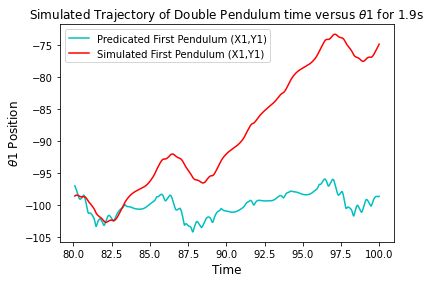

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta1$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta1$ for 1.9s')
plt.plot(data[:,0][8010:10000], rev_trans[:,1],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8010:10000],data[:,1][8010:10000],label='Simulated First Pendulum (X1,Y1)' ,color="red")
plt.legend()

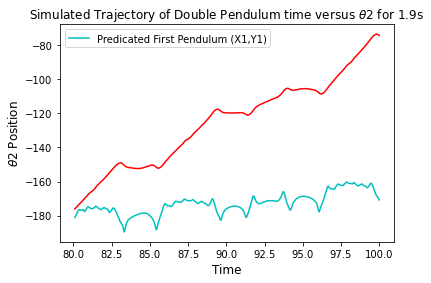

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta2$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta2$ for 1.9s')
plt.plot(data[:,0][8010:10000], rev_trans[:,3],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8010:10000],data[:,3][8010:10000],color="red")
plt.legend()

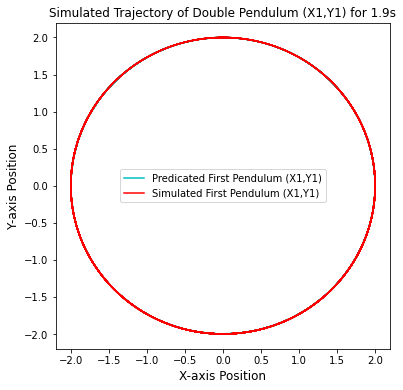

In [ ]:
plt.figure(figsize=(6,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X1,Y1) for 1.9s')
plt.plot(L1*sin(rev_trans[:,1]), -L1*cos(rev_trans[:,1]),label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(L1*sin(data[:,1][8010:10000]), -L1*cos(data[:,1][8010:10000]),label='Simulated First Pendulum (X1,Y1)' ,color="RED")
plt.legend()

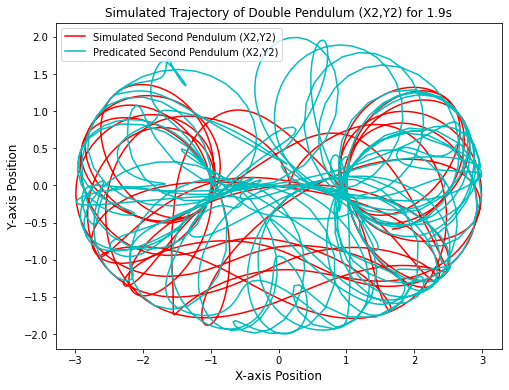

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X2,Y2) for 1.9s')
plt.plot(L2*sin(data[:,3][8010:10000])+L1*sin(data[:,1][8010:10000]), -L2*cos(data[:,3][8010:10000])-L2*cos(data[:,1][8010:10000]),label='Simulated Second Pendulum (X2,Y2)' ,color="RED")
plt.plot(L2*sin(rev_trans[:,3])+L1*sin(rev_trans[:,1]), -L2*cos(rev_trans[:,3])-L2*cos(rev_trans[:,1]),label='Predicated Second Pendulum (X2,Y2)' ,color="c")
plt.legend()

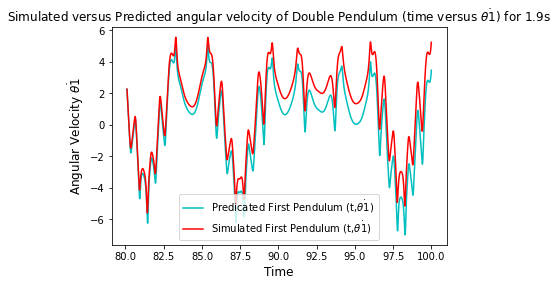

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta1}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta1}$) for 1.9s')
plt.plot(data[:,0][8010:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta1}$)' ,color="c")
plt.plot(data[:,0][8010:10000],data[:,2][8010:10000],label='Simulated First Pendulum (t,$\\dot{\\theta1}$)' ,color="red")
plt.legend()

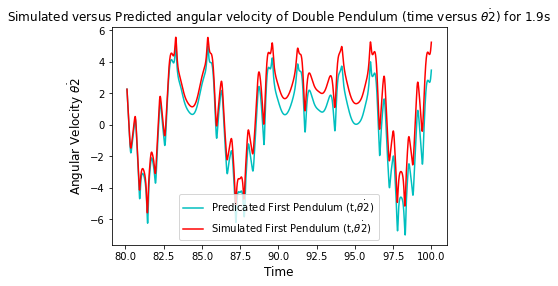

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta2}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta2}$) for 1.9s')
plt.plot(data[:,0][8010:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta2}$)' ,color="c")
plt.plot(data[:,0][8010:10000],data[:,2][8010:10000],label='Simulated First Pendulum (t,$\\dot{\\theta2}$)' ,color="red")
plt.legend()